# EDA of Taxi Data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import scipy.stats as stats

In [3]:
cab_data = pd.read_csv("Cab_Data.csv")
city_data = pd.read_csv("City.csv")
customer_data = pd.read_csv("Customer_ID.csv")
transaction_data = pd.read_csv("Transaction_ID.csv")

### Context-Checks

In [6]:
cab_data.head()

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip
0,10000011,42377,Pink Cab,ATLANTA GA,30.45,370.95,313.635
1,10000012,42375,Pink Cab,ATLANTA GA,28.62,358.52,334.854
2,10000013,42371,Pink Cab,ATLANTA GA,9.04,125.20,97.632
3,10000014,42376,Pink Cab,ATLANTA GA,33.17,377.40,351.602
4,10000015,42372,Pink Cab,ATLANTA GA,8.73,114.62,97.776


Consists of multiple records of journeys associated to transaction IDs, taken across different companies and cities. We also are given distance of journey, price charged, and the cost of the trip.

In [7]:
city_data.head()

,City,Population,Users
0,NEW YORK NY,"8,405,837","302,149"
1,CHICAGO IL,"1,955,130","164,468"
2,LOS ANGELES CA,"1,595,037","144,132"
3,MIAMI FL,"1,339,155","17,675"
4,SILICON VALLEY,"1,177,609","27,247"


Consists of various cities along with their populations and number of users.

In [8]:
customer_data.head()

,Customer ID,Gender,Age,Income (USD/Month)
0,29290,Male,28,10813
1,27703,Male,27,9237
2,28712,Male,53,11242
3,28020,Male,23,23327
4,27182,Male,33,8536


Provides further detail about customers, including gender, age and income data.

In [9]:
transaction_data.head()

,Transaction ID,Customer ID,Payment_Mode
0,10000011,29290,Card
1,10000012,27703,Card
2,10000013,28712,Cash
3,10000014,28020,Cash
4,10000015,27182,Card


Provides information about transactions, including payment method and customer ID, thus providing the link between customer_data and cab_data.

### Cleaning, Transforming & Joining

From our first look at the data, there are a few things we need to know how to do:

* Convert the dates of travel into meaningful dates.
* Convert the prices charged and costs of trip into profit made.
* Join frames into a master-frame.

In [10]:
(pd.to_datetime("31/12/2018", dayfirst=True) - pd.to_datetime("31/01/2016", dayfirst=True)).days 

1065

Including both ends of the interval we see that there are 1066 days in total over the given period. Now we note that the dates of travel are 40,000+ so hopefully they should just line up in terms of the minimum and maximum.

In [11]:
len(cab_data["Date of Travel"].unique())

1095

We see that the data doesn't line up with the given date information. However, we assume it is a typo, as starting the period from 1st January 2016 and ending at 31st December 2018 exclusive lines up well:

In [12]:
(pd.to_datetime("31/12/2018", dayfirst=True) - pd.to_datetime("01/01/2016", dayfirst=True)).days 

1095

In [13]:
dates = list(pd.date_range(start=pd.to_datetime("01/01/2016", dayfirst=True), end=pd.to_datetime("31/12/2018", dayfirst=True), inclusive="left"))
to_change = sorted(list(cab_data["Date of Travel"].unique()))
cab_data["Date of Travel"] = cab_data["Date of Travel"].map(lambda date: dates[to_change.index(date)])

In [14]:
cab_data["Profit"] = cab_data["Price Charged"] - cab_data["Cost of Trip"]

In [15]:
df1 = pd.merge(cab_data, transaction_data, on="Transaction ID", how="left")
#df1.info()
df2 = pd.merge(df1, customer_data, on="Customer ID", how="left")
#df2.info()
master_df = pd.merge(df2, city_data, on="City", how="left")
master_df.info()
#master_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359392 entries, 0 to 359391
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Transaction ID      359392 non-null  int64         
 1   Date of Travel      359392 non-null  datetime64[ns]
 2   Company             359392 non-null  object        
 3   City                359392 non-null  object        
 4   KM Travelled        359392 non-null  float64       
 5   Price Charged       359392 non-null  float64       
 6   Cost of Trip        359392 non-null  float64       
 7   Profit              359392 non-null  float64       
 8   Customer ID         359392 non-null  int64         
 9   Payment_Mode        359392 non-null  object        
 10  Gender              359392 non-null  object        
 11  Age                 359392 non-null  int64         
 12  Income (USD/Month)  359392 non-null  int64         
 13  Population          359392 no

Now we have a clean and well-prepared "master" dataframe which we will use for the analysis.

In [16]:
master_df.head()

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Profit,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month),Population,Users
0,10000011,2016-01-07,Pink Cab,ATLANTA GA,30.45,370.95,313.635,57.315,29290,Card,Male,28,10813,"814,885","24,701"
1,10000012,2016-01-05,Pink Cab,ATLANTA GA,28.62,358.52,334.854,23.666,27703,Card,Male,27,9237,"814,885","24,701"
2,10000013,2016-01-01,Pink Cab,ATLANTA GA,9.04,125.20,97.632,27.568,28712,Cash,Male,53,11242,"814,885","24,701"
3,10000014,2016-01-06,Pink Cab,ATLANTA GA,33.17,377.40,351.602,25.798,28020,Cash,Male,23,23327,"814,885","24,701"
4,10000015,2016-01-02,Pink Cab,ATLANTA GA,8.73,114.62,97.776,16.844,27182,Card,Male,33,8536,"814,885","24,701"


### EDA Analyses

#### Analysis 1: Profits 

We start off with a fairly obvious check: profits. 

The simplest way for comparing the difference between the two sets of profits would be a t-test to check for statistically significant difference in the means. 

However, there is very little parametrisation we can assume so we must be very careful. We can at the least assume that the two sets of profits are independent of one another. 

We will aim to apply Welch's t-test, which allows us to not assume equal variances, and allows us to not assume known variance for the underlying distribution. The only assumption we need to address is the assumption of normality, which is not a bad aspiration to have for profits.

We check for normality via a normal quantile plot.

In [59]:
def normal_quantile_plot(vals_dict):
    plt.figure(figsize=(5,5))
    for key, vals in vals_dict.items():
        new_vals = sorted(vals)
        zs = stats.norm.ppf(np.linspace(0, 1, len(new_vals)))
        plt.scatter(zs, new_vals, c=key, marker="o", s=5, label="Data Q-Q")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.title("Normal Quantile Plot for Both Companies")
    plt.grid(True)
    plt.show()    

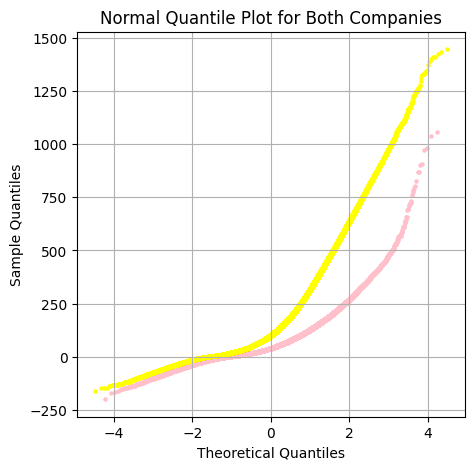

In [112]:
normal_quantile_plot({"pink": list(master_df[master_df["Company"]=="Pink Cab"]["Profit"]),
                      "yellow": list(master_df[master_df["Company"]=="Yellow Cab"]["Profit"])})

We actually do not see too much of a deviation from a straight line in the above normal quantile plot, so we are happy to proceed with applying the normality assumption.

We proceed by computing the t-test statistic for Welch's t-test, which requires us to calculate the variance estimators for each sample, sample means and the approximate degrees of freedom of the statistic's underlying distribution.

In [78]:
var_est_1 = sum((np.array(master_df[master_df["Company"]=="Pink Cab"]["Profit"])-master_df[master_df["Company"]=="Pink Cab"]["Profit"].mean())**2)/(len(master_df[master_df["Company"]=="Pink Cab"]["Profit"])-1)
var_est_2 = sum((np.array(master_df[master_df["Company"]=="Yellow Cab"]["Profit"])-master_df[master_df["Company"]=="Yellow Cab"]["Profit"].mean())**2)/(len(master_df[master_df["Company"]=="Yellow Cab"]["Profit"])-1)
n = len(master_df[master_df["Company"]=="Pink Cab"]["Profit"])
m = len(master_df[master_df["Company"]=="Yellow Cab"]["Profit"])

In [90]:
t_stat = abs((master_df[master_df["Company"]=="Pink Cab"]["Profit"].mean() - master_df[master_df["Company"]=="Yellow Cab"]["Profit"].mean())/math.sqrt(var_est_1/len(master_df[master_df["Company"]=="Pink Cab"]["Profit"])+var_est_2/len(master_df[master_df["Company"]=="Yellow Cab"]["Profit"])))
v = (var_est_1/n + var_est_2/m)**2/((var_est_1/n)**2/(n-1)+(var_est_2/m)**2/(m-1))
t_stat

230.99551452746206

In [93]:
print("Pink",master_df[master_df["Company"]=="Pink Cab"]["Profit"].mean(),"\nYellow:",master_df[master_df["Company"]=="Yellow Cab"]["Profit"].mean())

Pink 62.65217410961977 
Yellow: 160.25998584103016


We see above that the Yellow cab mean profit is much higher than that of the Pink cab, so we set the alternative hypothesis that the Yellow cab mean is statistically significantly higher than that of Pink cab - a one-tailed test.

In [95]:
stats.t.ppf(1-0.05, v)

1.6448584869755576

We see that our t-test value is much greater than the critical value, so, at the 5% significance level, by the Welch t-test we can conclude that the mean profit of the Yellow cab taxi company is statistically significantly higher than that of the Pink cab taxi company.

#### Analysis 2: Moving Averages of Profits

It is very tempting to simply leave our profit analysis where we left it above in Analysis 1 - after all, the difference in mean was both intuitively and statistically huge. However, it is important to do a qualitative check on whether this difference is well-spread; suppose this difference was concentrated at the start of the observation period, then it would be unreliable to assume the Yellow cab mean over time (because the mean is a function of time as well) is statistically significantly higher than that of the Pink cab.

Rigorously speaking, if we wanted to explore this statistically we would have to employ sophisticated time-series analysis. For our purposes here, since the observation period isn't too huge, and the statistical difference in means is so strong, we settle for a visual, qualitative analysis, suspecting it will line up with our beliefs.

We also note that precisely speaking, in Analysis 1, we concluded that the average profit per ride is greater in the Yellow cab company than the Pink cab company. Here we are looking at daily profits made by each company, so will have to perform some aggregation.

In [118]:
pink_daily_profits = master_df[master_df["Company"]=="Pink Cab"].groupby("Date of Travel")["Profit"].sum()
yellow_daily_profits = master_df[master_df["Company"]=="Yellow Cab"].groupby("Date of Travel")["Profit"].sum()

In [113]:
def moving_average_plotter(series_dict):
    plt.figure(figsize=(5,5))
    for key, vals in series_dict.items():
        plt.plot(pd.Series(vals).rolling(window=7).mean(), c=key)
    plt.xlabel("Dates")
    plt.ylabel("Rolling Average")
    plt.title("Weekly Moving Average for Daily Profits")
    plt.grid(True)
    plt.show()   
    

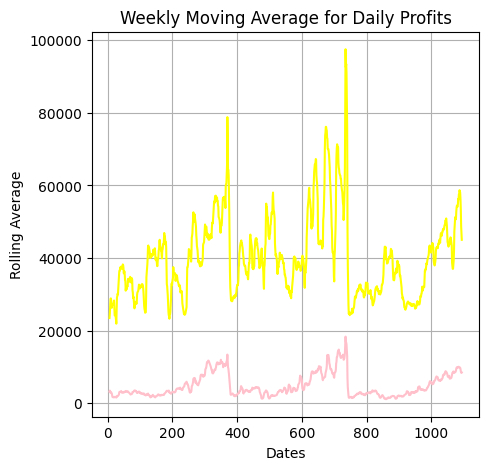

In [115]:
moving_average_plotter({"pink": list(pink_daily_profits),
                      "yellow": list(yellow_daily_profits)})

As suspected, we see that over time, the daily profits for the yellow cab company are drastically higher than that of the pink cab company. From our profits analyses it is now safe to say that the data-structures are in favour of the yellow cab company.

#### Analysis 3: Seasonality by Company

Looking at the weekly moving average above, it is interesting to observe slight patterns emerging in the data - some light seasonality analysis could provide insight. This makes intuitive sense as well, due to the fact that taxi usage is overwhelmingly linked to public holidays, events, weather etc.

It may be useful to leverage some third-party data here, or at the very least to split by location. From an intuitive perspective, it would be reasonable to think that such differing locations would have differing seasonalities. We perform a time-series seasonal decomposition analysis on an additive model to explore this.

In [153]:
import statsmodels.api as sm

In [192]:
pink_daily = master_df[master_df["Company"]=="Pink Cab"].groupby("Date of Travel")["Customer ID"].count()
yellow_daily = master_df[master_df["Company"]=="Yellow Cab"].groupby("Date of Travel")["Customer ID"].count()

decomp_pink = sm.tsa.seasonal_decompose(pink_daily, model='additive')
decomp_yellow = sm.tsa.seasonal_decompose(yellow_daily, model="additive")

Text(0.5, 1.0, 'Seasonal Component for Daily Useage by Company')

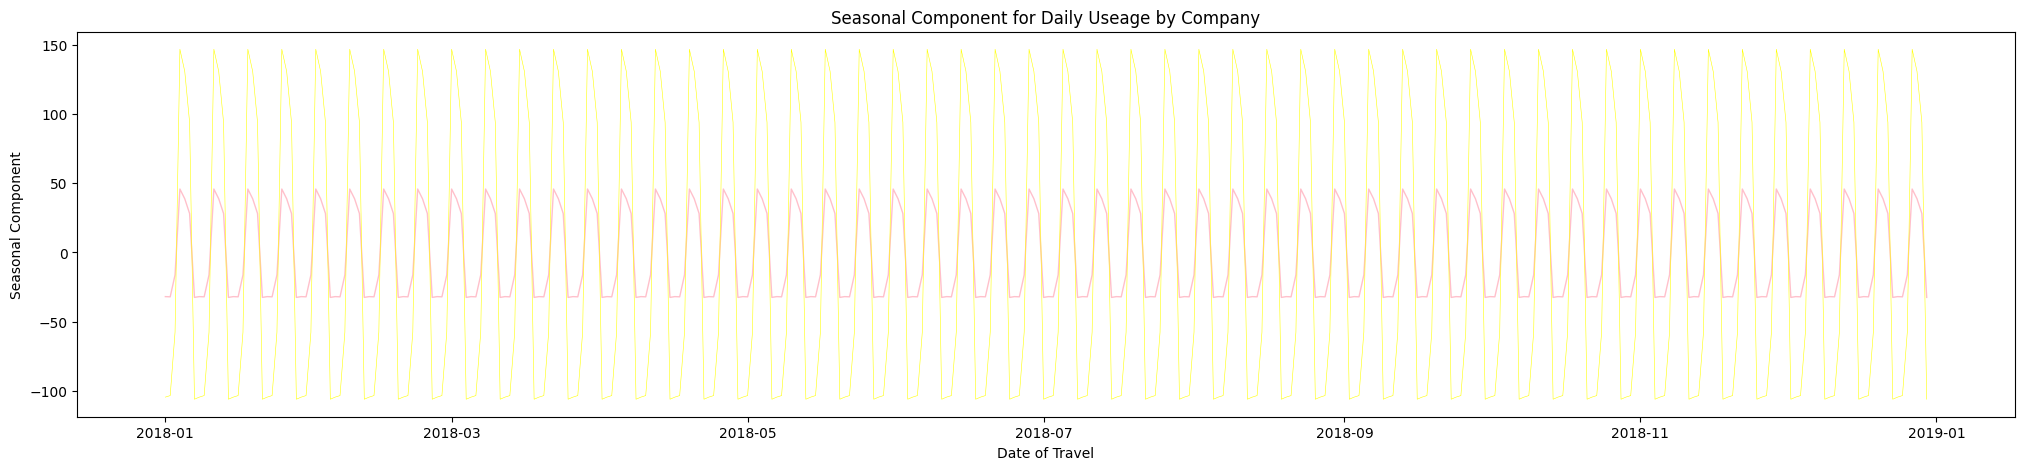

In [189]:
plt.figure(figsize=(25,5))
plt.plot(decomp_pink.seasonal[decomp_pink.seasonal.index >= '2018-01-01'], linewidth=1, c="pink")
plt.plot(decomp_yellow.seasonal[decomp_yellow.seasonal.index >= '2018-01-01'], linewidth=0.4, c="yellow")
plt.xlabel("Date of Travel")
plt.ylabel("Seasonal Component")
plt.title("Seasonal Component for Daily Useage by Company")

Text(0.5, 1.0, 'Trend Component for Daily Useage by Company')

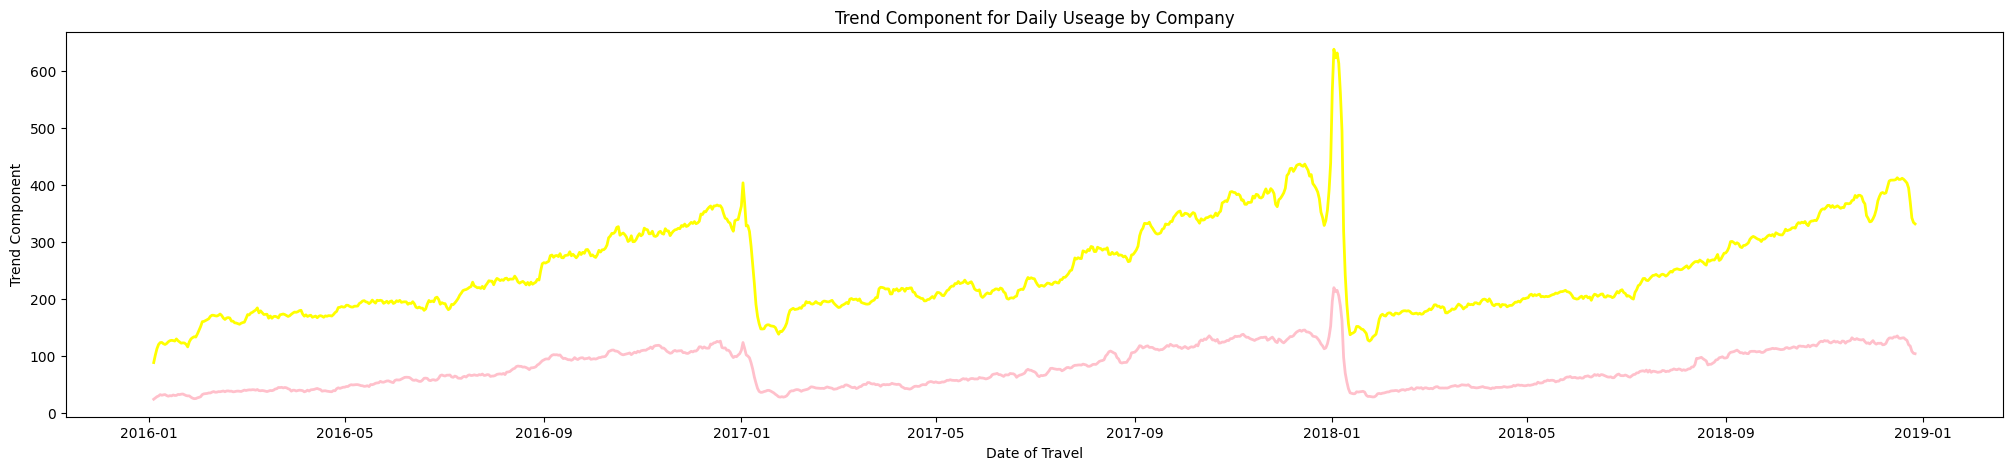

In [191]:
plt.figure(figsize=(25,5))
plt.plot(decomp_pink.trend, linewidth=2, c="pink")
plt.plot(decomp_yellow.trend, linewidth=2, c="yellow")
plt.xlabel("Date of Travel")
plt.ylabel("Trend Component")
plt.title("Trend Component for Daily Useage by Company")

From what we can see, there is not much new structure to be found in the seasonality and trend components in my additive time-series decomposition of the number of daily users. 

The seasonalities of both companies are fairly similar, as are the trends, which are positive for both companies, and can be seen to rise steadily throughout each year with a drop at the start of each year. The latter is curious, but not likely to shine any light on the analysis for our purposes, so we do not explore this further. However, we can safely conclude that the trend component for the yellow cab company is much higher; this allows us to reliably forecast the yellow cab company will stay on top in terms of popularity following the given time period.

#### Analysis 4: Income per Customer

Of course, it is useful to know that the overall trend for daily useage of the yellow company suggests that the yellow company will be much more popular going into the future. However, it is also important to consider the income of the users. With useage set to increase for both companies, we can foresee the profits of both companies increasing, and despite the fact that the yellow cab's profits were firmly above that of the pink cab company, we need to check that this is accounted for both in terms of useage and average income of customer.

As demand increases both companies will look to increase their prices, and a greater average of customer income would more likely allow this to happen. 

Though we haven't yet delved into location microstructure much, we will for the sake of this analysis. We will follow a similar workflow to the profits analysis, using Welch's t-test to allow us to avoid assuming equal (and known) variances. Despite this, we make sure to check the assumption of normality that the test imposes on its data.

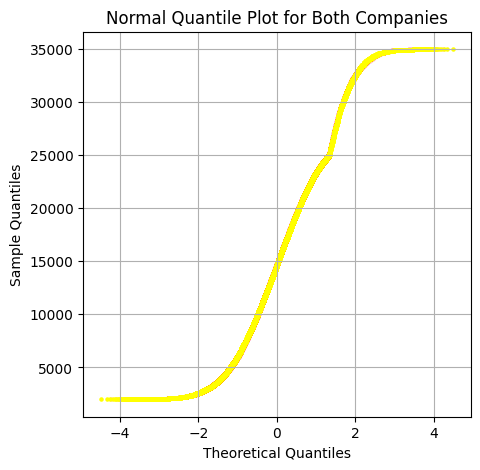

In [210]:
normal_quantile_plot({"pink": list(master_df[master_df["Company"]=="Pink Cab"]["Income (USD/Month)"]),
                      "yellow": list(master_df[master_df["Company"]=="Yellow Cab"]["Income (USD/Month)"])})

We see that a straight-line fit is not completely unreasonable here, so the underlying normality assumption is well-founded. We also mention the assumption of independence between incomes of the pink cab users and the yellow cab users.

In [211]:
cities = list(master_df["City"].unique())
pink = master_df[master_df["Company"]=="Pink Cab"].groupby("City")["Income (USD/Month)"].mean().reset_index()
yellow = master_df[master_df["Company"]=="Yellow Cab"].groupby("City")["Income (USD/Month)"].mean().reset_index()
pd.merge(yellow, pink, on="City").rename(columns={"Income (USD/Month)_x":"Mean Income, Pink",
                                                  "Income (USD/Month)_y":"Mean Income, Yellow"})

,City,"Mean Income, Pink","Mean Income, Yellow"
0,ATLANTA GA,14902.657981,15033.438706
1,AUSTIN TX,14593.396631,14863.617773
2,BOSTON MA,15074.554109,15383.779213
3,CHICAGO IL,15109.388393,15062.991561
4,DALLAS TX,14831.777896,14906.678261
5,DENVER CO,14946.052653,15027.279053
6,LOS ANGELES CA,15037.574872,15102.801057
7,MIAMI FL,15049.001797,14842.310689
8,NASHVILLE TN,14463.192472,14906.545899
9,NEW YORK NY,15195.245525,15120.299778


This is a really interesting set of results. It actually seems as though there might not be significant statistical difference in average customer income for each company in each city.

We will apply a two-sided Welch t-test at the 95% significance level over each location.

In [215]:
def var_est(s):
    return sum((np.array(s)-s.mean())**2)/(len(s)-1)

def t_stat(s1, s2):
    s1_bar = s1.mean()
    s2_bar = s2.mean()
    return abs(s1_bar-s2_bar)/math.sqrt(var_est(s1)/len(s1)+var_est(s2)/len(s2))
    
def v_approx(s1, s2):
    return (var_est(s1)/len(s1)+var_est(s2)/len(s2))**2/((var_est(s1)/len(s1))**2/(len(s1)-1)+((var_est(s2)/len(s2))**2/(len(s2)-1)))

def welcher(city_list, df):
    mapper = {True: "Statistically Significantly Different",
              False: "Not"}
    for city in city_list:
        s1 = df[(df["City"]==city)&(df["Company"]=="Pink Cab")]["Income (USD/Month)"]
        s2 = df[(df["City"]==city)&(df["Company"]=="Yellow Cab")]["Income (USD/Month)"]
        v = v_approx(s1, s2)
        t_crit = stats.t.ppf(1-0.025, v)
        t = t_stat(s1, s2)
        print(city,":",mapper[t>t_crit])

In [216]:
welcher(list(master_df["City"].unique()), master_df)

ATLANTA GA : Not
AUSTIN TX : Not
BOSTON MA : Statistically Significantly Different
CHICAGO IL : Not
DALLAS TX : Not
DENVER CO : Not
LOS ANGELES CA : Not
MIAMI FL : Not
NASHVILLE TN : Not
NEW YORK NY : Not
ORANGE COUNTY : Not
PHOENIX AZ : Not
PITTSBURGH PA : Not
SACRAMENTO CA : Not
SAN DIEGO CA : Not
SEATTLE WA : Not
SILICON VALLEY : Not
TUCSON AZ : Not
WASHINGTON DC : Statistically Significantly Different


Upon further inspection, we see that the pink cab company has richer customers in Washington DC and that the yellow cab company has richer customers in Boston MA.

To delve further into these colliding conclusions, we could assess further the customer data microstructure in each location. For example, if the yellow cab taxi company was trending on gaining more customers in Washington DC then this might compensate for the difference in mean income, and potentially increase it.

Despite these 2 small hurdles in our analysis, we don't give them enough weight to analyse further. Overall, in most cities, there is no statistically significant difference in mean income per customer across the companies. 

#### Analysis 5: Age Demographic between Companies

We make a comparison of age demographic between the two companies. This is with the idea that a company which appeals to a wider age range is likely to be more appealing for investment, since a wider target audience results in greater potential for profit overall.

<Axes: xlabel='Age', ylabel='Density'>

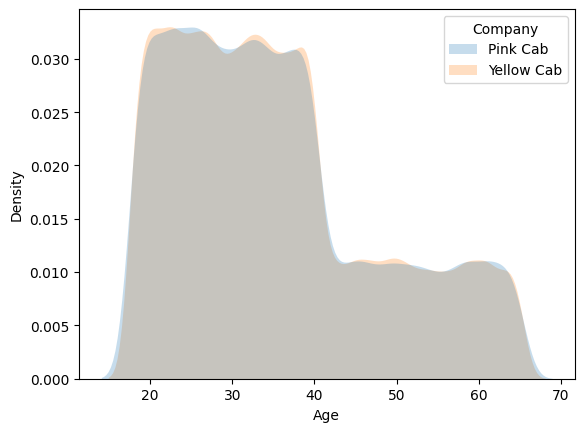

In [118]:
sns.kdeplot(data=master_df, x="Age", hue="Company", fill=True, linewidth=0, common_norm=False)

From this very quick qualitative check, we suspect that, though we may not be able to assume any kind of distribution on the ages to help us, it does look like the age distributions of the two companies are very similar.

To confirm a lack of difference in the distributions, we run a non-parametric Kolmogorov-Smirnov two-sample test; the null hypothesis being the underlying distributions (continuous) are the same, and the alternative being that they are different.

The test statistic for this test is the two-sided K-S statistic, given by the maximum vertical difference between the two empirical distributions.

In [140]:
def empirical_cumulative(vals, xs):
    n = len(vals)
    S = [sum(vals<=x)/n for x in list(xs)]
    return S

In [125]:
available_ages = [master_df["Age"].min(), master_df["Age"].max()]
available_ages

[18, 65]

In [157]:
S1 = empirical_cumulative(master_df[master_df["Company"]=="Pink Cab"]["Age"], np.arange(0, available_ages[1]+40,1))
S2 = empirical_cumulative(master_df[master_df["Company"]=="Yellow Cab"]["Age"], np.arange(0, available_ages[1]+40,1))

In [165]:
KS = max(abs(np.array(S1)-np.array(S2)))

The 95% critical value is approximated by 1.36 multiplied by the square root of the sum of the reciprocals of the sample sizes of each distribution.

In [170]:
KS >= 1.36*math.sqrt(1/len(master_df[master_df["Company"]=="Pink Cab"]["Age"])+1/len(master_df[master_df["Company"]=="Yellow Cab"]["Age"]))

False

We see from the above that at the 5% significance level (i.e. with 95% confidence) we can conclude that there is not statistically significant difference between the two age distributions, so there is not much useful information to extract here.

## Conclusions & Further Thoughts

Our conclusion on the business problem is clear: the yellow cab taxi company is a much better investment overall. Throughout our analyses, there were no significant rulings in favour of the pink cab taxi company, so this is a fair and clear decision to make.


There are a few criticisms to make following this analysis:

* The given time period is not necessarily reliable for an investment through to 2023. The prevailing reason for this is the pandemic. We have not given much thought to what attributes make a taxi company durable through a pandemic. Perhaps we could have linked third-party data about travel regulations in differing locations during the pandemic. The US was notorious for having different COVID guidelines to much of the world, but different cities had different cultures surrounding how to handle the pandemic and therefore public transport. There would have been a lot of interesting detail to explore here, but this would require multiple reports in its own right, so we have left this level of detail out for now.
* Overall there was much more microstructure to explore regarding location data. That being said, the difference between the two companies in our analyses on the macroscopic level doesn't seem to justify much further exploration of this.